In [31]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import re

In [32]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read data from file

In [33]:
def get_data(stopword_removal = 'no'):
  content = []
  with open('/content/sample_for_word2vec.txt', 'r') as f:
    content = f.read()
    txt =[]
    for sentences in content.split('.'):
      sentences = re.findall("[A-Za-z]+", sentences)
      #print(sentences)
      new_line = ''
      
      for line in sentences:
        if stopword_removal == 'yes':
          if len(line) > 1 and line not in stop_words:
            new_line = new_line + ' ' +line
        
        else:
          if len(line) > 1:
            new_line = new_line + ' ' +line
      txt.append(new_line)
  return txt

In [34]:
# test on above function
get_data('no')[0]

' Abel dies soon after and bequeathes everything to his daughter Florentyna except his silver band of authority which he leaves to his grandson whom Florentyna and Richard have named William Abel Kane'

## Generate variables



word_to_index : A dictionary mapping each word to an integer value {'modern': 0, 'humans': 1}

index_to_word : A dictionary mapping each word to an integer value {0: 'modern', 1: 'humans'}

corpus  : The entire data consisting of all the words

vocab_size : Number of unique words in the corpus

In [57]:
def generate_variables(texts):
  corpus = []
  word_to_id = dict()
  id_to_word = dict()
  vocab_size = 0
  count = 0
  for txt in texts:
    for word in txt.split():
      word = word.lower()
      corpus.append(word)
      if word_to_id.get(word) == None:
        word_to_id.update ( {word : count} )
        id_to_word.update ( {count : word} )
        count = count + 1
  vocab_size = len(word_to_id)
  corpus_length = len(corpus)
  return corpus, word_to_id, id_to_word, vocab_size, corpus_length


In [58]:
# test on above function
corpus, word_to_id, id_to_word, vocab_size, corpus_length = generate_variables(['Not that every glitter is gold. Life is all about success'])
print('Number of unique words:' , vocab_size)
print('word_to_index : ',word_to_id)
print('index_to_word : ',id_to_word)
print('corpus:',corpus)
print('Length of corpus :',corpus_length)

Number of unique words: 10
word_to_index :  {'not': 0, 'that': 1, 'every': 2, 'glitter': 3, 'is': 4, 'gold.': 5, 'life': 6, 'all': 7, 'about': 8, 'success': 9}
index_to_word :  {0: 'not', 1: 'that', 2: 'every', 3: 'glitter', 4: 'is', 5: 'gold.', 6: 'life', 7: 'all', 8: 'about', 9: 'success'}
corpus: ['not', 'that', 'every', 'glitter', 'is', 'gold.', 'life', 'is', 'all', 'about', 'success']
Length of corpus : 11


## Generate training data

In [49]:
def get_one_hot_vector(target_word, context_word, vocab_size, word_to_id):
  target_wrd_vector = np.zeros(vocab_size)
  index_of_target_word = word_to_id.get(target_word)
  target_wrd_vector[index_of_target_word] = 1 #set the index value to 1

  ctxt_wrd_vector = np.zeros(vocab_size)
  for word in context_word:
    index_of_cntxt_word = word_to_id.get(word)
    target_wrd_vector[index_of_cntxt_word] = 1

  return target_wrd_vector, ctxt_wrd_vector

In [75]:
def generate_training_data(corpus, window_size, vocab_size, word_to_id, length_of_corpus, sample = None):

  training_data = []
  training_sample_words = []
  for i , word in enumerate(corpus):

    index_target_word = i
    target_word = word
    context_word =[]

    #when target word is first word
    if i == 0:
      context_word = [corpus[x] for x in range(i+1, window_size + 1)]

    #when target word is last word
    elif i == len(corpus) - 1:
      context_word = [corpus[x] for x in range(length_of_corpus-2, length_of_corpus -2 - window_size, -1)]

    #when target word is the middle word
    else:
      before_trgt_wrd_index = index_target_word -1
      #when context word is before middle target word
      for x in range(before_trgt_wrd_index, before_trgt_wrd_index - window_size, -1):
        if x >=0:
          context_word.extend([corpus[x]])

      after_trgt_wrd_index = index_target_word +1
      #when context word is after middle target word
      for x in range(after_trgt_wrd_index, after_trgt_wrd_index + window_size):
        if x < len(corpus):
          context_word.append(corpus[x])


    target_wrd_vector, ctxt_wrd_vector = get_one_hot_vector(target_word, context_word, vocab_size, word_to_id)
    training_data.append([target_wrd_vector, ctxt_wrd_vector])

    if sample is not None:
      training_sample_words.append([target_word, context_word])

  return training_data, training_sample_words

In [76]:
text = ['Not that every glitter is gold. Life is all about success and enjoy every moment']

In [77]:
corpus, word_to_id, id_to_word, vocab_size, corpus_length = generate_variables(text)

In [78]:
window_size = 2
training_data,training_sample_words = generate_training_data(corpus,2,vocab_size,word_to_id,corpus_length,'yes')

In [79]:
for i in range(len(training_data)):
    print('*' * 50)
    print('Target word:%s . Target vector: %s ' %(training_sample_words[i][0],training_data[i][0]))
    print('Context word:%s . Context  vector: %s ' %(training_sample_words[i][1],training_data[i][1]))

**************************************************
Target word:not . Target vector: [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Context word:['that', 'every'] . Context  vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
**************************************************
Target word:that . Target vector: [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Context word:['not', 'every', 'glitter'] . Context  vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
**************************************************
Target word:every . Target vector: [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 
Context word:['that', 'not', 'glitter', 'is'] . Context  vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
**************************************************
Target word:glitter . Target vector: [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] 
Context word:['every', 'that', 'is', 'gold.'] . Context  vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
**************************************************
Target word:is . Target vector

## Forward_prop

In [80]:
def forward_prop(inp_hidden_wts, out_hidden_wts, target_wrd_vector):

  hidden_layer = np.dot(inp_hidden_wts.T,target_wrd_vector)

  u = np.dot(out_hidden_wts.T, hidden_layer)

  y_predicted = softmax(u)

  return y_predicted, hidden_layer, u

In [81]:
def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis=0)

## Backward Pro

In [102]:
def backward_prop(inp_hidden_wts, out_hidden_wts, hidden_layer, total_error, target_wrd_vector, learning_rate):
  dl_weight_inp_hidden = np.outer(target_wrd_vector, np.dot(out_hidden_wts, total_error.T))
  dl_weight_hidden_output = np.outer(hidden_layer, total_error)

  # Update weights
  weight_inp_hidden = inp_hidden_wts - (learning_rate * dl_weight_inp_hidden)
  weight_hidden_output = out_hidden_wts - (learning_rate * dl_weight_hidden_output)
    
  return weight_inp_hidden,weight_hidden_output

## Loss and error calculation

In [83]:
def calculate_error(y_pred,context_words):
    
    total_error = [None] * len(y_pred)
    index_of_1_in_context_words = {}
    
    for index in np.where(context_words == 1)[0]:
        index_of_1_in_context_words.update ( {index : 'yes'} )
        
    number_of_1_in_context_vector = len(index_of_1_in_context_words)
    
    for i,value in enumerate(y_pred):
        
        if index_of_1_in_context_words.get(i) != None:
            total_error[i]= (value-1) + ( (number_of_1_in_context_vector -1) * value)
        else:
            total_error[i]= (number_of_1_in_context_vector * value)
            
            
    return  np.array(total_error)

In [84]:
def calculate_loss(u,ctx):
    
    sum_1 = 0
    for index in np.where(ctx==1)[0]:
        sum_1 = sum_1 + u[index]
    
    sum_1 = -sum_1
    sum_2 = len(np.where(ctx==1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    return total_loss

In [100]:
def train(word_embedding_dimension,window_size,epochs,training_data,learning_rate,disp = 'no',interval=-1):
    
    weights_input_hidden = np.random.uniform(-1, 1, (vocab_size, word_embedding_dimension))
    weights_hidden_output = np.random.uniform(-1, 1, (word_embedding_dimension, vocab_size))
    
    
    #For analysis purposes
    epoch_loss = []
    weights_1 = []
    weights_2 = []
    
    for epoch in range(epochs):
        loss = 0

        for target,context in training_data:
            y_pred, hidden_layer, u = forward_prop(weights_input_hidden,weights_hidden_output,target)

            total_error = calculate_error(y_pred, context)

            weights_input_hidden,weights_hidden_output = backward_prop(
                weights_input_hidden,weights_hidden_output , hidden_layer,total_error, target,learning_rate
            )

            loss_temp = calculate_loss(u,context)
            loss += loss_temp
        
        epoch_loss.append( loss )
        weights_1.append(weights_input_hidden)
        weights_2.append(weights_hidden_output)
        
        if disp == 'yes':
            if epoch ==0 or epoch % interval ==0 or epoch == epochs -1:
                print('Epoch: %s. Loss:%s' %(epoch,loss))
    return epoch_loss,np.array(weights_1),np.array(weights_2)

###Distance measure between vectors

In [87]:
def cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word):
    
    #Get the index of the word from the dictionary
    index = word_to_index[word]
    
    #Get the correspondin weights for the word
    word_vector_1 = weight[index]
    
    
    word_similarity = {}

    for i in range(vocab_size):
        
        word_vector_2 = weight[i]
        
        theta_sum = np.dot(word_vector_1, word_vector_2)
        theta_den = np.linalg.norm(word_vector_1) * np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den
        
        word = index_to_word[i]
        word_similarity[word] = theta
    
    return word_similarity #words_sorted

### Print a matrix of similar words

In [88]:
def print_similar_words(top_n_words,weight,msg,words_subset):
    
    columns=[]
    
    for i in range(0,len(words_subset)):
        columns.append('similar:' +str(i+1) )
        
    df = pd.DataFrame(columns=columns,index=words_subset)
    df.head()
    
    row = 0
    for word in words_subset:
        
        #Get the similarity matrix for the word: word
        similarity_matrix = cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word)
        col = 0
        
        #Sort the top_n_words
        words_sorted = dict(sorted(similarity_matrix.items(), key=lambda x: x[1], reverse=True)[1:top_n_words+1])
        
        #Create a dataframe to display the similarity matrix
        for similar_word,similarity_value in words_sorted.items():
            df.iloc[row][col] = (similar_word,round(similarity_value,2))
            col += 1
        row += 1
    styles = [dict(selector='caption', 
    props=[('text-align', 'center'),('font-size', '20px'),('color', 'red')])] 
    df = df.style.set_properties(**
                       {'color': 'green','border-color': 'blue','font-size':'14px'}
                      ).set_table_styles(styles).set_caption(msg)
    return df

### Plot words as scatter plot from T-Sne

In [89]:
def word_similarity_scatter_plot(index_to_word,weight,plot_title,fig,axes):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    #TSNE : Compressing the weights to 2 dimensions to plot the data
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    #plt.figure(figsize=(5, 5)) 
    for i in range(len(x)):
        axes.scatter(x[i],y[i])
        axes.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.title(plot_title)
    axes.set_title(plot_title, loc='center')

### Epoch - loss plot

In [90]:
def plot_epoch_loss(lbl,loss_epoch,plot_title,path):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    i = 0
    fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k',dpi=80)
    plt.suptitle('Epoch vs Loss',fontsize=16)
    
    for key,loss in loss_epoch.items():
        
        
        epoch_count = range(1, len(loss) + 1)

        plt.plot(epoch_count, loss, 'r-',color=colors[i],linewidth=2.0,label = lbl + str(key))

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        i += 1

    plt.legend(framealpha=1, frameon=True,fontsize='large',edgecolor="inherit",shadow=True)
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.show()
    plt.close()

In [98]:
path_to_save = '/content/epoc_loss_plot/'
path_to_save_scatter_plot = '/content/word_similarity_scatter_plot/'

In [93]:
window_size = 2
epochs = 100
learning_rate = 0.01
text = ['Best way to success is through hardwork and persistence']

In [95]:
corpus, word_to_id, id_to_word, vocab_size, corpus_length = generate_variables(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_id,corpus_length)

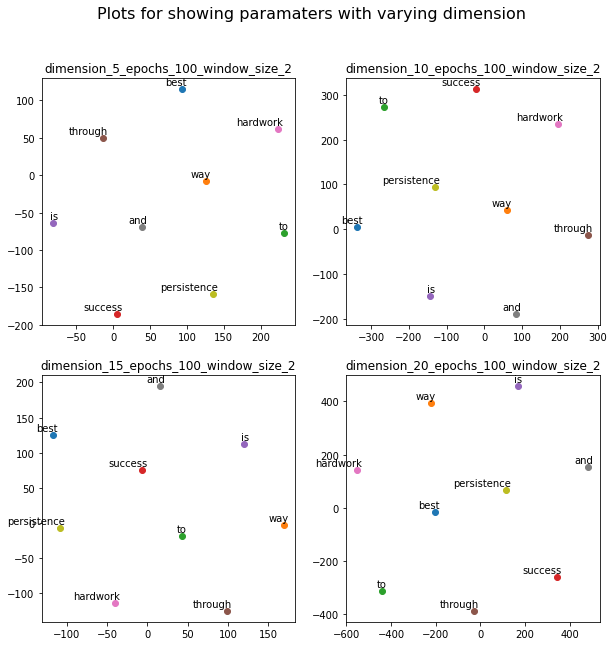

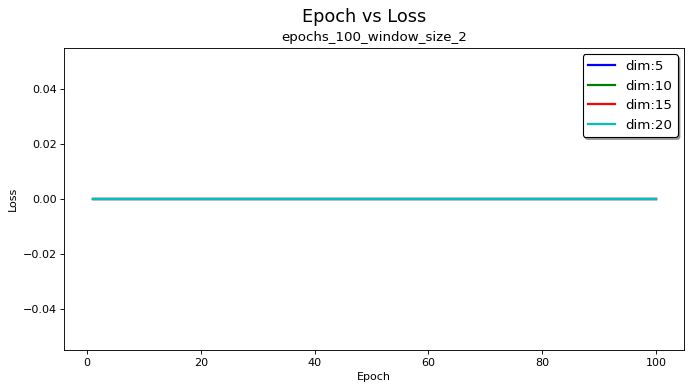

In [109]:
dimensions = [5,10,15,20]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying dimension", fontsize=16)
row=0
col=0
for dim in dimensions:
    
    epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate)
    loss_epoch.update( {dim: epoch_loss} )
    
    word_similarity_scatter_plot(
        id_to_word,
        weights_1[epochs -1],
        'dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        fig, axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1

#plt.savefig(path_to_save_scatter_plot+'varying_dim' +'.png')        
plt.show()

plot_epoch_loss('dim:',loss_epoch,'epochs_' + str(epochs) + '_window_size_' +str(window_size), path = '')

In [111]:
dimension = 20
epochs = 100
learning_rate = 0.01
text = ['Best way to success is through hardwork and persistence']

corpus,word_to_index,index_to_word,vocab_size,length_of_corpus = generate_variables(text)

#varying dimension

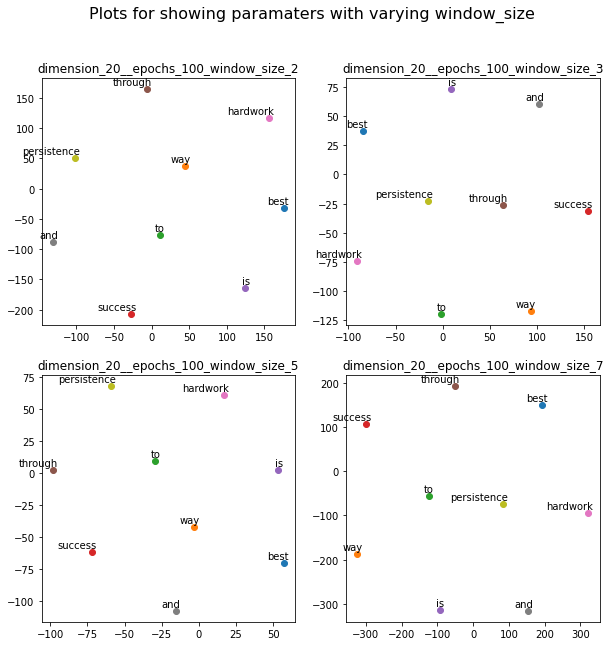

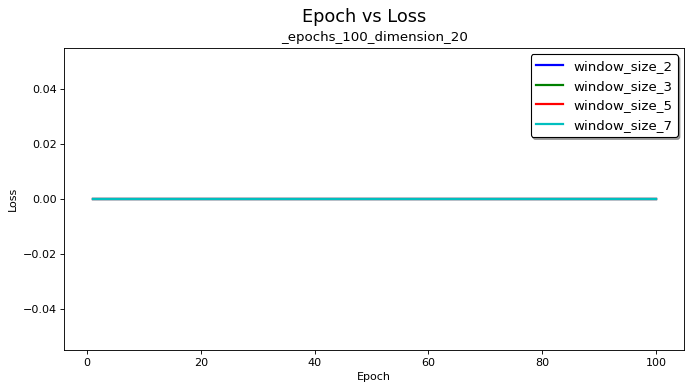

In [115]:
window_size = [2,3,5,7]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying window_size", fontsize=16)
row=0
col=0
for ws in window_size:
    
    training_data,training_sample_words = generate_training_data(corpus,ws,vocab_size,word_to_index,length_of_corpus)
    
    epoch_loss,weights_1,weights_2 = train(dimension,ws,epochs,training_data,learning_rate)
    loss_epoch.update( {ws: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epochs -1],
        'dimension_20_' + '_epochs_' + str(epochs) + '_window_size_' +str(ws),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1
#plt.savefig(path_to_save_scatter_plot+'varying_window_size' +'.png')                
plt.show()
plot_epoch_loss('window_size_',loss_epoch,'_epochs_' + str(epochs) + '_dimension_20', path = '')

## Using pretrained model of gensim library

In [119]:
data = get_data('yes')

In [120]:
data

[' Abel dies soon bequeathes everything daughter Florentyna except silver band authority leaves grandson Florentyna Richard named William Abel Kane',
 ' Harry Clifton joined British Navy assumed identity Tom Bradshaw ship sinks order solve problems never knowing end prison serve Bradshaw sentence desertion',
 ' In prison meets Pat Quinn quickly starts learning prison trades',
 ' After hard work ends prison librarian begins writing The Diary Convict',
 ' Back England Wallace informs everyone death later burial Harry sea',
 ' Emma Giles sister Harry girlfriend goes meet Maisie Harry Mother',
 ' While letter Tom Bradshaw Harry lying Maisie mantelpiece Emma recognizes handwriting believes Harry still alive',
 ' Not allowed open letter sets find Harry',
 ' She works Kansas Star ship Harry saved gets know people Tom Bradshaw last moments',
 ' On visiting home realize Harry Tom prison',
 ' Harry meanwhile writes diary time prison',
 ' When one fellow inmates Max Lloyd released requests Harry 

In [135]:
all_words = []
for sent in data:
  tokens  =[]
  for word in sent.split():
    word = word.lower()
    tokens.append(word)
  all_words.append(tokens)

In [136]:
all_words

[['abel',
  'dies',
  'soon',
  'bequeathes',
  'everything',
  'daughter',
  'florentyna',
  'except',
  'silver',
  'band',
  'authority',
  'leaves',
  'grandson',
  'florentyna',
  'richard',
  'named',
  'william',
  'abel',
  'kane'],
 ['harry',
  'clifton',
  'joined',
  'british',
  'navy',
  'assumed',
  'identity',
  'tom',
  'bradshaw',
  'ship',
  'sinks',
  'order',
  'solve',
  'problems',
  'never',
  'knowing',
  'end',
  'prison',
  'serve',
  'bradshaw',
  'sentence',
  'desertion'],
 ['in',
  'prison',
  'meets',
  'pat',
  'quinn',
  'quickly',
  'starts',
  'learning',
  'prison',
  'trades'],
 ['after',
  'hard',
  'work',
  'ends',
  'prison',
  'librarian',
  'begins',
  'writing',
  'the',
  'diary',
  'convict'],
 ['back',
  'england',
  'wallace',
  'informs',
  'everyone',
  'death',
  'later',
  'burial',
  'harry',
  'sea'],
 ['emma',
  'giles',
  'sister',
  'harry',
  'girlfriend',
  'goes',
  'meet',
  'maisie',
  'harry',
  'mother'],
 ['while',
  'let

In [137]:
import gensim
from gensim.models import Word2Vec

In [138]:
word2vec = Word2Vec(all_words, min_count=2)

In [144]:
vocabulary = word2vec.wv.vocab
print(vocabulary)

{'abel': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece6b790>, 'dies': <gensim.models.keyedvectors.Vocab object at 0x7fe5ea1291d0>, 'soon': <gensim.models.keyedvectors.Vocab object at 0x7fe5ea129110>, 'everything': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5e7d0>, 'daughter': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5e950>, 'florentyna': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5e9d0>, 'leaves': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5ea50>, 'grandson': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5ea90>, 'richard': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5e910>, 'named': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5efd0>, 'william': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5eb10>, 'kane': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5eb50>, 'harry': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5ebd0>, 'clifton': <gensim.models.keyedvectors.Vocab object at 0x7fe5ece5ec10>, 

In [141]:
v1 = word2vec.wv['times']
v1

array([-2.8438035e-03,  4.9984194e-03,  1.2608129e-03, -2.2274221e-03,
       -4.6900450e-03,  8.2291182e-05, -6.0257042e-04, -3.9975834e-03,
       -4.7449642e-03, -1.5077600e-03,  2.4173229e-03,  3.9277375e-03,
        3.7928289e-04,  4.1101412e-03, -4.7090417e-03, -7.6586124e-04,
        1.9244431e-03, -3.8339666e-03, -3.2082254e-03,  1.9146014e-03,
       -1.5396511e-03,  3.2334686e-03,  3.5026453e-03, -9.1031735e-04,
       -2.4569207e-03, -2.2576943e-03, -4.9848208e-05, -2.6329702e-03,
       -1.0990810e-03, -3.9897473e-03,  2.9331632e-03,  4.7172012e-04,
       -2.7263777e-03,  1.4753753e-03, -3.4040122e-03,  5.0240117e-03,
       -1.9413751e-03,  1.5044197e-03, -8.8814425e-04, -1.1134631e-03,
       -2.4947375e-03,  3.7769142e-03, -4.8264153e-03,  2.5343287e-03,
        3.4704127e-03, -3.8200417e-03, -3.2254292e-03, -5.6175701e-04,
       -3.7656932e-03,  4.1013607e-03,  3.6409013e-03, -2.0913593e-03,
       -3.1890322e-03,  1.1292407e-03,  2.5692333e-03,  2.3928673e-03,
      